In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, classification_report

In [4]:
beneficiary_data = pd.read_csv("/content/Train_Beneficiarydata-1542865627584.csv")
inpatient_data = pd.read_csv("/content/Train_Inpatientdata-1542865627584.csv")
outpatient_data = pd.read_csv("/content/Train_Outpatientdata-1542865627584.csv")
main_data = pd.read_csv("/content/Train-1542865627584.csv")

In [ ]:
claims_data = pd.concat([inpatient_data, outpatient_data], ignore_index=True)

# Aggregate claim-related data
claims_agg = claims_data.groupby("Provider").agg({
    "InscClaimAmtReimbursed": "sum",
    "BeneID": "nunique",  # Unique patients per provider
    "ClaimID": "count"      # Total claims per provider
}).reset_index()

In [ ]:
merged_data = pd.merge(main_data, claims_agg, on="Provider", how="left")

In [ ]:
le = LabelEncoder()
merged_data["PotentialFraud"] = le.fit_transform(merged_data["PotentialFraud"])

In [ ]:
X = merged_data.drop(columns=["Provider", "PotentialFraud"])
y = merged_data["PotentialFraud"]

In [ ]:

X.fillna(0, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
smote = SMOTE(sampling_strategy=0.7, random_state=42)  # Oversample minority class up to 70%
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  # Undersample majority class to 70%
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, y_train = under.fit_resample(X_train, y_train)

counter = Counter(y_train)
print("After resampling:", counter)

After resampling: Counter({0: 3925, 1: 2748})


In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [14]:
ann_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optimizer = Adam(learning_rate=0.05)
ann_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [17]:
ann_model.fit(X_train, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test, y_test_cat), callbacks=[lr_scheduler, early_stopping])


Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7919 - loss: 0.6647 - val_accuracy: 0.0970 - val_loss: 0.8307 - learning_rate: 0.0500
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8268 - loss: 0.4471 - val_accuracy: 0.0970 - val_loss: 1.2124 - learning_rate: 0.0500
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8282 - loss: 0.4497 - val_accuracy: 0.7505 - val_loss: 0.5879 - learning_rate: 0.0500
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8367 - loss: 0.4233 - val_accuracy: 0.4797 - val_loss: 0.6976 - learning_rate: 0.0500
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8117 - loss: 0.4532 - val_accuracy: 0.8189 - val_loss: 0.2370 - learning_rate: 0.0500
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7753 - loss: 0.4440 - val_accuracy: 0.9224 - val_loss: 0.3198 - learning_rate: 0.0500
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7721 - loss: 0.4630 -

In [18]:
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)
print("\nANN Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ann)}")
print(classification_report(y_test, y_pred_ann))

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

ANN Model Evaluation:
Accuracy: 0.9269870609981515
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       977
           1       0.84      0.30      0.45       105

    accuracy                           0.93      1082
   macro avg       0.89      0.65      0.70      1082
weighted avg       0.92      0.93      0.91      1082



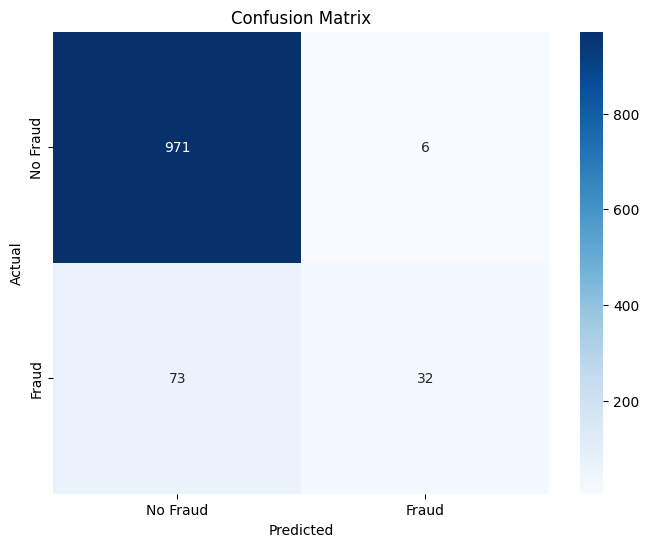

In [22]:
cm = confusion_matrix(y_test, y_pred_ann)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fraud', 'Fraud'],
            yticklabels=['No Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
